### Import Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

### Data Collection & Preprocessing

In [2]:
data=pd.read_csv('Emotions_training.csv')

In [3]:
data.isnull().sum()

text     0
label    0
dtype: int64

#### Lower Case

In [4]:
data["text"] = data["text"].str.lower()

#### Removing links

In [5]:
data['text'] = data['text'].fillna('')

In [6]:
no_url=[]
# Iterate through each sentence in the "text" column of the data
for sentence in data["text"]:
    # Use regular expression to substitute URLs with an empty string, effectively removing them
    no_url.append(re.sub(r"http\S+", "", sentence))

# Replace the "text" column in the data with the list of sentences without URLs
data["text"]=no_url

#### Remove next lines

In [7]:
data['text'] = data['text'].str.replace('\n', '')

#### Removing words containing numbers

In [8]:
pattern = r'\b\w*\d\w*\b'
def remove_words_with_numbers(text):
    return re.sub(pattern, '', text)
data['text'] = data['text'].apply(remove_words_with_numbers)

#### Removing extra spaces

In [9]:
data['text'] = data['text'].apply(lambda x: ' '.join(x.split()))

#### Removing special characters

In [10]:
no_special_char=[]
for sentence in data.text:
    no_special_char.append(re.sub('[^A-Za-z0-9]+', ' ', sentence))
data["text"]=no_special_char

#### Removing HTML tags

In [11]:
def remove_html_tags(text):
    pattern=re.compile('<.*?>')
    return pattern.sub(r' ',text)
data['text']=data['text'].apply(remove_html_tags)

#### Removal of stop words

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def remove_stopwords(text):
    # Split the text into words and iterate through each word
    # Only keep the word if it's not in the list of stopwords
    # Join the remaining words back together into a single string
    filtered_text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return filtered_text

In [14]:
data['text'] = data['text'].apply(remove_stopwords)

In [15]:
data['text'].head()

0                                didnt feel humiliated
1    go feeling hopeless damned hopeful around some...
2            im grabbing minute post feel greedy wrong
3    ever feeling nostalgic fireplace know still pr...
4                                      feeling grouchy
Name: text, dtype: object

#### Stemming

In [16]:
stemmer = PorterStemmer()

In [17]:
def stem_text(text):
     # Split the text into words and iterate through each word
    # Apply stemming to each word using the stemmer object
    # Join the stemmed words back together into a single string
    return " ".join([stemmer.stem(word) for word in text.split()])

In [18]:
data['text'] = data['text'].apply(stem_text)

#### Lemmatization

In [19]:
def lemmatize_text(text):
    wnl = WordNetLemmatizer()
    # Split the text into words and iterate through each word
    # Apply lemmatization to each word using the lemmatize() method of the WordNetLemmatizer object
    # Join the lemmatized words back together into a single string
    return " ".join([wnl.lemmatize(word) for word in text.split()])

In [20]:
data['text'] = data['text'].apply(lemmatize_text)

In [21]:
data['text'].head()

0                                    didnt feel humili
1    go feel hopeless damn hope around someon care ...
2                 im grab minut post feel greedi wrong
3       ever feel nostalg fireplac know still properti
4                                         feel grouchi
Name: text, dtype: object

In [22]:
#Class Distribution
data['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

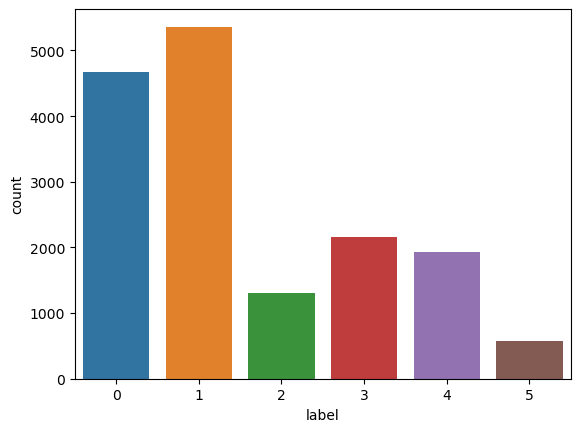

In [23]:
sns.countplot(x='label',data=data)

In [24]:
class_names = {0:'Sadness', 1:'Joy', 2:'Love', 3:'Anger', 4:'Fear', 5:'Surprise'}

In [25]:
X=data['text']
y=data['label']

### Vectorization

In [26]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Convert the raw text data (X) into TF-IDF vectors
X_vec = vectorizer.fit_transform(X)

### SMOTE Algorithm

In [27]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vec, y)

In [28]:
class_counts = y_resampled.value_counts()

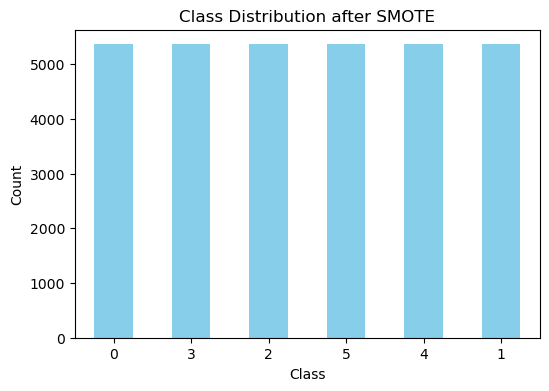

In [29]:
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution after SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [30]:
# List of algorithms or models
algorithm = ['Random Forest', 'Logistic Regression', 'Naive Bayes', 'SVM', 'XGBoost']

# Lists to store accuracy scores for different metrics
before_train = []  # Accuracy scores before hyperparameter tuning on the training set
before_test = []   # Accuracy scores before hyperparameter tuning on the testing set
after_train = []   # Accuracy scores after hyperparameter tuning on the training set
after_test = []    # Accuracy scores after hyperparameter tuning on the testing set
val = []           # Validation accuracy scores
param=[]           #Best parameter of hyperparameter tuning

### Split the data into test and train sets

In [31]:
# Splitted data into 70-20-10 for training-testing-validation

In [32]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42) 

In [33]:
X_train,X_val,y_train,y_val=train_test_split(X_train_temp,y_train_temp,test_size=0.10,random_state=42)

### Random Forest

In [34]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Make predictions on the training data
y_train_pred = rf_classifier.predict(X_train)
# Make predictions on the testing data
y_test_pred = rf_classifier.predict(X_test)

In [36]:
# Calculate the accuracy score for the training predictions
rf_train_acc = accuracy_score(y_train, y_train_pred)
# Calculate the accuracy score for the testing predictions
rf_test_acc = accuracy_score(y_test, y_test_pred)

In [37]:
print("Training Accuracy:", rf_train_acc)
print("Testing Accuracy:", rf_test_acc)

Training Accuracy: 0.9992660708889177
Testing Accuracy: 0.9283605283605284


In [38]:
before_train.append(rf_train_acc)
before_test.append(rf_test_acc)

In [39]:
cm = confusion_matrix(y_train,y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3847    0    0    3    0    0]
 [   0 3867    8    0    0    1]
 [   0    1 3887    0    0    0]
 [   0    0    0 3884    1    0]
 [   1    0    0    0 3853    1]
 [   0    0    0    0    1 3808]]


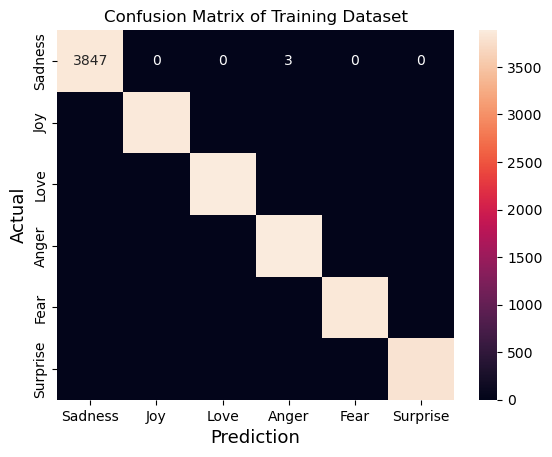

In [40]:
sns.heatmap(cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Training Dataset',fontsize=12)
plt.show()

In [41]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 927   73   20   36   24    7]
 [  40  900   82   23   18   15]
 [   2   20 1036    0    0    1]
 [  14   18    1 1020    3    1]
 [   7    9    6   20 1021   18]
 [   0    0    0    0    3 1070]]


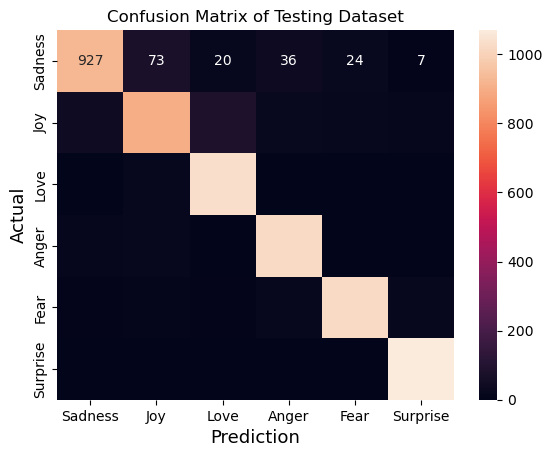

In [42]:
sns.heatmap(test_cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Testing Dataset',fontsize=12)
plt.show()

In [43]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3850
           1       1.00      1.00      1.00      3876
           2       1.00      1.00      1.00      3888
           3       1.00      1.00      1.00      3885
           4       1.00      1.00      1.00      3855
           5       1.00      1.00      1.00      3809

    accuracy                           1.00     23163
   macro avg       1.00      1.00      1.00     23163
weighted avg       1.00      1.00      1.00     23163



In [44]:
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      1087
           1       0.88      0.83      0.86      1078
           2       0.90      0.98      0.94      1059
           3       0.93      0.96      0.95      1057
           4       0.96      0.94      0.95      1081
           5       0.96      1.00      0.98      1073

    accuracy                           0.93      6435
   macro avg       0.93      0.93      0.93      6435
weighted avg       0.93      0.93      0.93      6435



#### Hyeperparameter Tuning

In [45]:
# Define a grid of hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100],            # Number of trees in the forest
    'max_depth': [5, 10],                  # Maximum depth of the trees
    'min_samples_split': [2, 5],           # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2]             # Minimum number of samples required to be at a leaf node
}

In [46]:
rfc = RandomForestClassifier()

In [47]:
# Create a GridSearchCV object
rf_grid = GridSearchCV(
    estimator=rf_classifier,    # The model or estimator to use (Random Forest classifier)
    param_grid=param_grid,      # The grid of hyperparameters to search over
    cv=5,                       # Cross-validation strategy (5-fold cross-validation)
    scoring='accuracy',         # Scoring metric to optimize (accuracy)
    verbose=2,                  # Controls the verbosity of the output (more details)
    n_jobs=-1                   # Number of jobs to run in parallel (-1 uses all available CPU cores)
)

In [48]:
# Fit the GridSearchCV object to the training data
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [49]:
print("Best Parameters:", rf_grid.best_params_)
param.append(rf_grid.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [50]:
best_rf_classifier = rf_grid.best_estimator_

In [51]:
# Make predictions on the training data using the best RandomForestClassifier
y_train_pred = best_rf_classifier.predict(X_train)
# Make predictions on the testing data using the best RandomForestClassifier
y_test_pred = best_rf_classifier.predict(X_test)
# Make predictions on the validation data using the best RandomForestClassifier
y_val_pred = best_rf_classifier.predict(X_val)

In [52]:
# Calculate the accuracy score for the training predictions using the best RandomForestClassifier
rf_train_hpt = accuracy_score(y_train, y_train_pred)
# Calculate the accuracy score for the testing predictions using the best RandomForestClassifier
rf_test_hpt = accuracy_score(y_test, y_test_pred)
# Calculate the accuracy score for the validation predictions using the best RandomForestClassifier
rf_val_hpt = accuracy_score(y_val, y_val_pred)

In [53]:
print("Training Accuracy with Best Estimator:", rf_train_hpt)
print("Testing Accuracy with Best Estimator:", rf_test_hpt)
print("Validation Accuracy with Best Estimator:", rf_val_hpt)

Training Accuracy with Best Estimator: 0.833009541078444
Testing Accuracy with Best Estimator: 0.8108780108780109
Validation Accuracy with Best Estimator: 0.8166278166278166


In [54]:
after_train.append(rf_train_hpt)
after_test.append(rf_test_hpt)
val.append(rf_val_hpt)

In [55]:
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[2626  695  191  166  101   71]
 [ 487 2761  416   61   62   89]
 [  24  135 3708    8    5    8]
 [ 103  218  105 3397   51   11]
 [  79  273   57   68 3064  314]
 [   8   43   16    0    3 3739]]


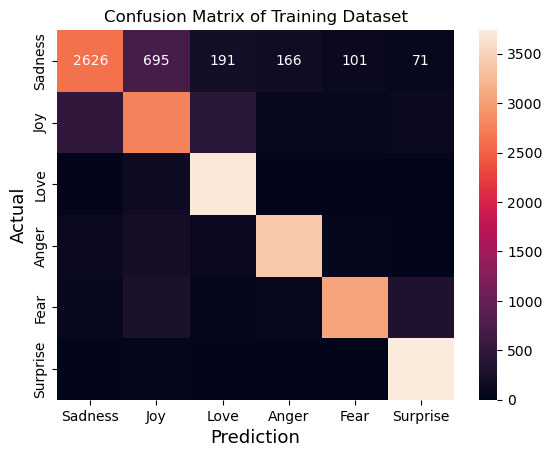

In [56]:
sns.heatmap(cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Training Dataset',fontsize=12)
plt.show()

In [57]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 704  227   60   45   34   17]
 [ 144  737  134   13   23   27]
 [   7   40 1005    2    2    3]
 [  27   68   34  912    8    8]
 [  26   87   21   29  811  107]
 [   2   11    6    0    5 1049]]


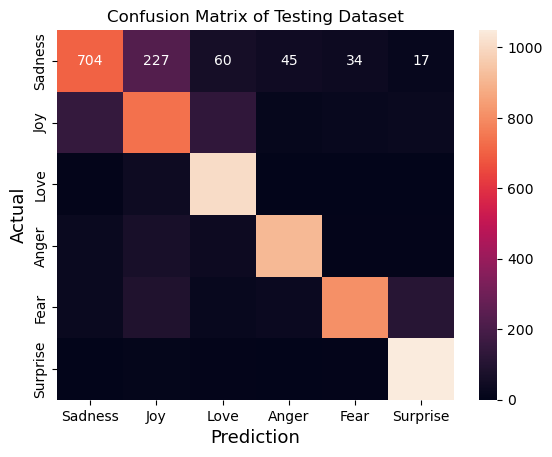

In [58]:
sns.heatmap(test_cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Testing Dataset',fontsize=12)
plt.show()

In [59]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73      3850
           1       0.67      0.71      0.69      3876
           2       0.83      0.95      0.88      3888
           3       0.92      0.87      0.90      3885
           4       0.93      0.79      0.86      3855
           5       0.88      0.98      0.93      3809

    accuracy                           0.83     23163
   macro avg       0.84      0.83      0.83     23163
weighted avg       0.84      0.83      0.83     23163



In [60]:
report_rf= classification_report(y_test, y_test_pred,output_dict=True)
print("Classification Report with Best Estimator:\n",classification_report(y_test, y_test_pred))

Classification Report with Best Estimator:
               precision    recall  f1-score   support

           0       0.77      0.65      0.71      1087
           1       0.63      0.68      0.66      1078
           2       0.80      0.95      0.87      1059
           3       0.91      0.86      0.89      1057
           4       0.92      0.75      0.83      1081
           5       0.87      0.98      0.92      1073

    accuracy                           0.81      6435
   macro avg       0.82      0.81      0.81      6435
weighted avg       0.82      0.81      0.81      6435



In [61]:
print("Classification Report on Training Data:\n",classification_report(y_val, y_val_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.77      0.64      0.70       425
           1       0.63      0.68      0.65       408
           2       0.78      0.95      0.86       415
           3       0.91      0.85      0.88       420
           4       0.93      0.77      0.84       426
           5       0.89      0.98      0.94       480

    accuracy                           0.82      2574
   macro avg       0.82      0.81      0.81      2574
weighted avg       0.82      0.82      0.81      2574



### Logistic Regression

In [62]:
log_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
log_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, multi_class='multinomial')

In [63]:
y_train_pred = log_classifier.predict(X_train)
y_test_pred = log_classifier.predict(X_test)

In [64]:
log_train_acc = accuracy_score(y_train, y_train_pred)
log_test_acc = accuracy_score(y_test, y_test_pred)

In [65]:
print("Training Accuracy:", log_train_acc)
print("Testing Accuracy:", log_test_acc)

Training Accuracy: 0.9576479730604844
Testing Accuracy: 0.9283605283605284


In [66]:
before_train.append(log_train_acc)
before_test.append(log_test_acc)

In [67]:
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3630   52   27   71   45   25]
 [  54 3538  181   37   26   40]
 [   7   66 3796   11    6    2]
 [  44   20    9 3781   26    5]
 [  26   19   12   38 3636  124]
 [   2    2    0    0    4 3801]]


In [68]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 971   41   16   31   20    8]
 [  29  950   67    8    8   16]
 [   4   33 1015    5    1    1]
 [  24   20    3 1000    9    1]
 [  15   15    7   18  971   55]
 [   1    1    1    0    3 1067]]


In [69]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      3850
           1       0.96      0.91      0.93      3876
           2       0.94      0.98      0.96      3888
           3       0.96      0.97      0.97      3885
           4       0.97      0.94      0.96      3855
           5       0.95      1.00      0.97      3809

    accuracy                           0.96     23163
   macro avg       0.96      0.96      0.96     23163
weighted avg       0.96      0.96      0.96     23163



In [70]:
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      1087
           1       0.90      0.88      0.89      1078
           2       0.92      0.96      0.94      1059
           3       0.94      0.95      0.94      1057
           4       0.96      0.90      0.93      1081
           5       0.93      0.99      0.96      1073

    accuracy                           0.93      6435
   macro avg       0.93      0.93      0.93      6435
weighted avg       0.93      0.93      0.93      6435



#### Hyeperparameter Tuning

In [71]:
# Define a grid of hyperparameters to search over for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                # Regularization parameter (smaller values specify stronger regularization)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Optimization algorithm to use for the logistic regression model
}

In [72]:
log_reg = LogisticRegression(max_iter=1000)

In [73]:
# Create a GridSearchCV object for Logistic Regression
log_grid = GridSearchCV(
    estimator=log_reg,         # The logistic regression model
    param_grid=param_grid,     # The grid of hyperparameters to search over
    cv=5,                      # Cross-validation strategy (5-fold cross-validation)
    n_jobs=-1,                 # Number of jobs to run in parallel (-1 uses all available CPU cores)
    verbose=2                 # Controls the verbosity of the output (more details)
)

In [74]:
# Fit the GridSearchCV object to the training data
log_grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=2)

In [75]:
print("Best Parameters:", log_grid.best_params_)
param.append(log_grid.best_params_)

Best Parameters: {'C': 10, 'solver': 'newton-cg'}


In [76]:
best_log_reg = log_grid.best_estimator_

In [77]:
# Make predictions on the training data using the best Logistic Regression model
y_train_pred = best_log_reg.predict(X_train)
# Make predictions on the testing data using the best Logistic Regression model
y_test_pred = best_log_reg.predict(X_test)
# Make predictions on the validation data using the best Logistic Regression model
y_val_pred = best_log_reg.predict(X_val)

In [78]:
log_train_hpt = accuracy_score(y_train, y_train_pred)
log_test_hpt = accuracy_score(y_test, y_test_pred)
log_val_hpt = accuracy_score(y_val, y_val_pred)

In [79]:
print("Training Accuracy with Best Estimator:", log_train_hpt)
print("Testing Accuracy with Best Estimator:", log_test_hpt)
print("Validation Accuracy with Best Estimator:", log_val_hpt)

Training Accuracy with Best Estimator: 0.9877822389155118
Testing Accuracy with Best Estimator: 0.9415695415695415
Validation Accuracy with Best Estimator: 0.947940947940948


In [80]:
after_train.append(log_train_hpt)
after_test.append(log_test_hpt)
val.append(log_val_hpt)

In [81]:
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3787    9    3   32   17    2]
 [  19 3766   65    8    8   10]
 [   0   12 3875    1    0    0]
 [  10    1    1 3857   16    0]
 [   7    1    1   14 3789   43]
 [   0    1    0    0    2 3806]]


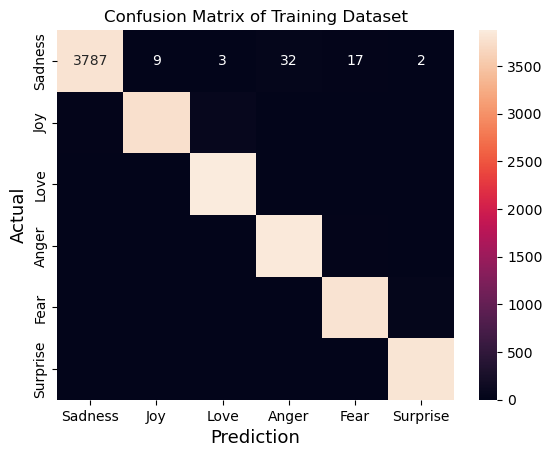

In [82]:
sns.heatmap(cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Training Dataset',fontsize=12)
plt.show()

In [83]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 987   39   15   30   13    3]
 [  30  960   61   10    7   10]
 [   2   25 1031    0    1    0]
 [  25   14    4 1006    8    0]
 [  13   12    4   15 1008   29]
 [   1    3    0    0    2 1067]]


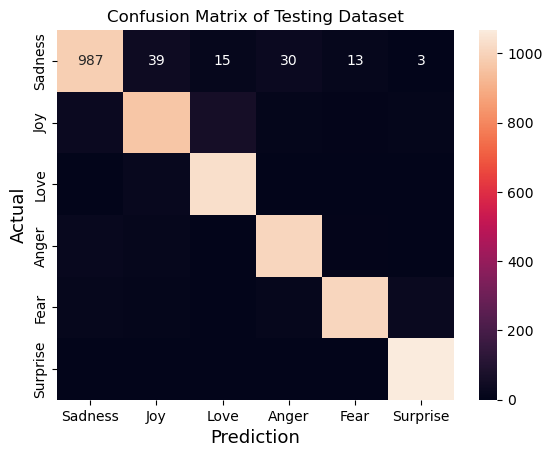

In [84]:
sns.heatmap(test_cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Testing Dataset',fontsize=12)
plt.show()

In [85]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3850
           1       0.99      0.97      0.98      3876
           2       0.98      1.00      0.99      3888
           3       0.99      0.99      0.99      3885
           4       0.99      0.98      0.99      3855
           5       0.99      1.00      0.99      3809

    accuracy                           0.99     23163
   macro avg       0.99      0.99      0.99     23163
weighted avg       0.99      0.99      0.99     23163



In [86]:
report_log=classification_report(y_test, y_test_pred,output_dict=True)
print("Classification Report on Testing Data:\n",classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      1087
           1       0.91      0.89      0.90      1078
           2       0.92      0.97      0.95      1059
           3       0.95      0.95      0.95      1057
           4       0.97      0.93      0.95      1081
           5       0.96      0.99      0.98      1073

    accuracy                           0.94      6435
   macro avg       0.94      0.94      0.94      6435
weighted avg       0.94      0.94      0.94      6435



In [87]:
print("Classification Report on Validation Data:\n",classification_report(y_val, y_val_pred))

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       425
           1       0.91      0.90      0.90       408
           2       0.91      0.98      0.94       415
           3       0.96      0.96      0.96       420
           4       0.98      0.96      0.97       426
           5       0.98      1.00      0.99       480

    accuracy                           0.95      2574
   macro avg       0.95      0.95      0.95      2574
weighted avg       0.95      0.95      0.95      2574



### Naive Bayes Classifier

In [88]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [89]:
y_train_pred = nb_classifier.predict(X_train)
y_test_pred = nb_classifier.predict(X_test)

In [90]:
nb_train_acc = accuracy_score(y_train, y_train_pred)
nb_test_acc = accuracy_score(y_test, y_test_pred)

In [91]:
print("Training Accuracy:", nb_train_acc)
print("Testing Accuracy:", nb_test_acc)

Training Accuracy: 0.9438760091525278
Testing Accuracy: 0.9053613053613053


In [92]:
before_train.append(nb_train_acc)
before_test.append(nb_test_acc)

In [93]:
cm = confusion_matrix(y_train,y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3595   55   31   68   55   46]
 [  87 3412  217   52   37   71]
 [  13   75 3770   13    5   12]
 [  52   26   23 3712   62   10]
 [  36   19    6   44 3574  176]
 [   2    4    0    0    3 3800]]


In [94]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 934   46   25   43   26   13]
 [  46  863  100   17   23   29]
 [   8   29 1015    6    1    0]
 [  28   13   11  983   15    7]
 [  15    3    7   17  965   74]
 [   0    2    0    0    5 1066]]


In [95]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      3850
           1       0.95      0.88      0.91      3876
           2       0.93      0.97      0.95      3888
           3       0.95      0.96      0.95      3885
           4       0.96      0.93      0.94      3855
           5       0.92      1.00      0.96      3809

    accuracy                           0.94     23163
   macro avg       0.94      0.94      0.94     23163
weighted avg       0.94      0.94      0.94     23163



In [96]:
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1087
           1       0.90      0.80      0.85      1078
           2       0.88      0.96      0.92      1059
           3       0.92      0.93      0.93      1057
           4       0.93      0.89      0.91      1081
           5       0.90      0.99      0.94      1073

    accuracy                           0.91      6435
   macro avg       0.91      0.91      0.90      6435
weighted avg       0.91      0.91      0.90      6435



#### Hyeperparameter Tuning

In [97]:
# Define a grid of hyperparameters to search over for Naive Bayes
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]  # Additive smoothing parameter
}

In [98]:
nb = MultinomialNB()

In [99]:
# Create a GridSearchCV object for Naive Bayes
nb_grid = GridSearchCV(
    estimator=nb,               # The Naive Bayes model
    param_grid=param_grid,     # The grid of hyperparameters to search over
    cv=5,                      # Cross-validation strategy (5-fold cross-validation)
    scoring='accuracy',        # Scoring metric to optimize (accuracy)
    n_jobs=-1,                 # Number of jobs to run in parallel (-1 uses all available CPU cores)
    verbose=2                  # Controls the verbosity of the output (more details)
)

In [100]:
nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]},
             scoring='accuracy', verbose=2)

In [101]:
print("Best Parameters:", nb_grid.best_params_)
param.append(nb_grid.best_params_)

Best Parameters: {'alpha': 0.5}


In [102]:
best_nb = nb_grid.best_estimator_

In [103]:
# Make predictions on the training data using the best Naive Bayes model
y_train_pred = best_nb.predict(X_train)
# Make predictions on the testing data using the best Naive Bayes model
y_test_pred = best_nb.predict(X_test)
# Make predictions on the validation data using the best Naive Bayes model
y_val_pred = best_nb.predict(X_val)

In [104]:
# Calculate the accuracy score for the training predictions using the best Naive Bayes model
nb_train_hpt = accuracy_score(y_train, y_train_pred)
# Calculate the accuracy score for the testing predictions using the best Naive Bayes model
nb_test_hpt = accuracy_score(y_test, y_test_pred)
# Calculate the accuracy score for the validation predictions using the best Naive Bayes model
nb_val_hpt = accuracy_score(y_val, y_val_pred)

In [105]:
print("Training Accuracy with Best Estimator:", nb_train_hpt)
print("Testing Accuracy with Best Estimator:", nb_test_hpt)
print("Testing Accuracy with Best Estimator:", nb_val_hpt)

Training Accuracy with Best Estimator: 0.9495747528385787
Testing Accuracy with Best Estimator: 0.9042735042735043
Testing Accuracy with Best Estimator: 0.9075369075369075


In [106]:
after_train.append(nb_train_hpt)
after_test.append(nb_test_hpt)
val.append(nb_val_hpt)

In [107]:
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3632   48   26   59   49   36]
 [  80 3461  196   42   34   63]
 [  15   73 3776   12    4    8]
 [  49   20   19 3724   63   10]
 [  36   17    6   42 3603  151]
 [   2    5    0    0    3 3799]]


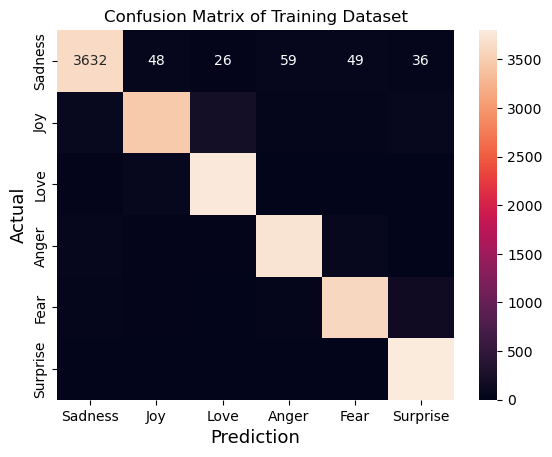

In [108]:
sns.heatmap(cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Training Dataset',fontsize=12)
plt.show()

In [109]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 931   47   23   45   28   13]
 [  53  857   91   21   29   27]
 [   9   30 1011    7    2    0]
 [  26   19    9  979   16    8]
 [  13    6    9   16  975   62]
 [   0    2    0    0    5 1066]]


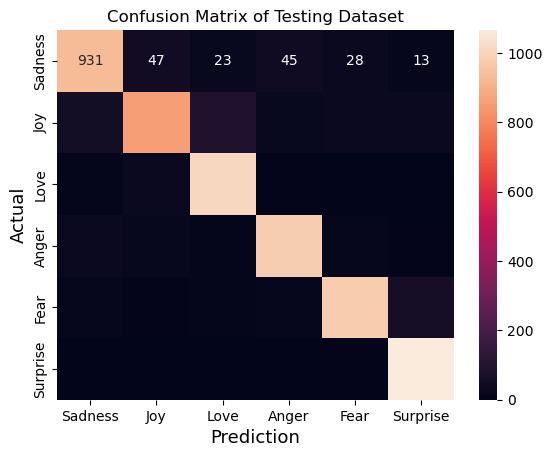

In [110]:
sns.heatmap(test_cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Testing Dataset',fontsize=12)
plt.show()

In [111]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      3850
           1       0.96      0.89      0.92      3876
           2       0.94      0.97      0.95      3888
           3       0.96      0.96      0.96      3885
           4       0.96      0.93      0.95      3855
           5       0.93      1.00      0.96      3809

    accuracy                           0.95     23163
   macro avg       0.95      0.95      0.95     23163
weighted avg       0.95      0.95      0.95     23163



In [112]:
report_nb=classification_report(y_test, y_test_pred,output_dict=True)
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1087
           1       0.89      0.79      0.84      1078
           2       0.88      0.95      0.92      1059
           3       0.92      0.93      0.92      1057
           4       0.92      0.90      0.91      1081
           5       0.91      0.99      0.95      1073

    accuracy                           0.90      6435
   macro avg       0.90      0.90      0.90      6435
weighted avg       0.90      0.90      0.90      6435



In [113]:
print("Classification Report on Validation Data:\n",classification_report(y_val, y_val_pred))

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87       425
           1       0.86      0.81      0.84       408
           2       0.87      0.95      0.91       415
           3       0.91      0.95      0.93       420
           4       0.93      0.90      0.92       426
           5       0.94      0.99      0.96       480

    accuracy                           0.91      2574
   macro avg       0.91      0.91      0.90      2574
weighted avg       0.91      0.91      0.91      2574



### Linear Support Vector Machine

In [114]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [115]:
y_train_pred = svm_classifier.predict(X_train)
y_test_pred = svm_classifier.predict(X_test)

In [116]:
svm_train_acc = accuracy_score(y_train, y_train_pred)
svm_test_acc = accuracy_score(y_test, y_test_pred)

In [117]:
print("Training Accuracy:", svm_train_acc)
print("Testing Accuracy:", svm_test_acc)

Training Accuracy: 0.9671458792039028
Testing Accuracy: 0.9317793317793318


In [118]:
before_train.append(svm_train_acc)
before_test.append(svm_test_acc)

In [119]:
cm = confusion_matrix(y_train,y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3657   28   23   70   50   22]
 [  51 3566  159   41   26   33]
 [   2   28 3853    4    0    1]
 [  28    9    7 3816   24    1]
 [  13    5    6   28 3704   99]
 [   0    0    0    0    3 3806]]


In [120]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 966   33   18   37   25    8]
 [  33  922   79   13   14   17]
 [   3   27 1027    1    1    0]
 [  21   12    3 1010   11    0]
 [  10    8    2   17 1001   43]
 [   0    0    0    0    3 1070]]


In [121]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      3850
           1       0.98      0.92      0.95      3876
           2       0.95      0.99      0.97      3888
           3       0.96      0.98      0.97      3885
           4       0.97      0.96      0.97      3855
           5       0.96      1.00      0.98      3809

    accuracy                           0.97     23163
   macro avg       0.97      0.97      0.97     23163
weighted avg       0.97      0.97      0.97     23163



In [122]:
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      1087
           1       0.92      0.86      0.89      1078
           2       0.91      0.97      0.94      1059
           3       0.94      0.96      0.95      1057
           4       0.95      0.93      0.94      1081
           5       0.94      1.00      0.97      1073

    accuracy                           0.93      6435
   macro avg       0.93      0.93      0.93      6435
weighted avg       0.93      0.93      0.93      6435



#### Hyeperparameter Tuning

In [123]:
# Define a grid of hyperparameters to search over for Support Vector Machine (SVM)
param_grid = {
    'C': [0.01, 0.1, 1, 10]  # Regularization parameter
}

In [124]:
svm_classifier = SVC(kernel='linear')

In [125]:
# Create a GridSearchCV object for Support Vector Machine (SVM)
svm_grid = GridSearchCV(
    estimator=svm_classifier,   # The SVM classifier
    param_grid=param_grid,      # The grid of hyperparameters to search over
    cv=5,                       # Cross-validation strategy (5-fold cross-validation)
    scoring='accuracy',         # Scoring metric to optimize (accuracy)
    n_jobs=-1,                  # Number of jobs to run in parallel (-1 uses all available CPU cores)
    verbose=2                   # Controls the verbosity of the output (more details)
)

In [126]:
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='accuracy',
             verbose=2)

In [127]:
print("Best Parameters:", svm_grid.best_params_)
param.append(svm_grid.best_params_)

Best Parameters: {'C': 10}


In [128]:
best_svm = svm_grid.best_estimator_

In [129]:
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)
y_val_pred = best_svm.predict(X_val)

In [130]:
svm_train_hpt = accuracy_score(y_train, y_train_pred)
svm_test_hpt = accuracy_score(y_test, y_test_pred)
svm_val_hpt = accuracy_score(y_val, y_val_pred)

In [131]:
print("Training Accuracy with Best Estimator:", svm_train_hpt)
print("Testing Accuracy with Best Estimator:", svm_test_hpt)
print("Validation Accuracy with Best Estimator:", svm_val_hpt)

Training Accuracy with Best Estimator: 0.9936536718041704
Testing Accuracy with Best Estimator: 0.9358197358197358
Validation Accuracy with Best Estimator: 0.9374514374514374


In [132]:
after_train.append(svm_train_hpt)
after_test.append(svm_test_hpt)
val.append(svm_val_hpt)

In [133]:
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3815    6    0   21    7    1]
 [   7 3823   37    2    3    4]
 [   0    1 3887    0    0    0]
 [   3    0    0 3870   12    0]
 [   1    0    0   12 3812   30]
 [   0    0    0    0    0 3809]]


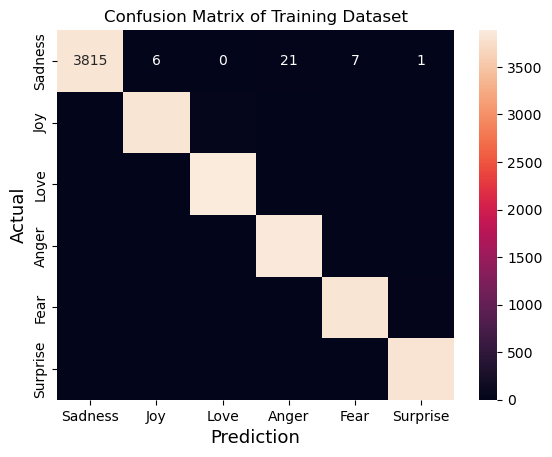

In [134]:
sns.heatmap(cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Training Dataset',fontsize=12)
plt.show()

In [135]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 967   44   12   42   17    5]
 [  51  930   66   13    8   10]
 [   2   18 1037    1    1    0]
 [  30   19    3  997    8    0]
 [  15   10    4   11 1020   21]
 [   0    2    0    0    0 1071]]


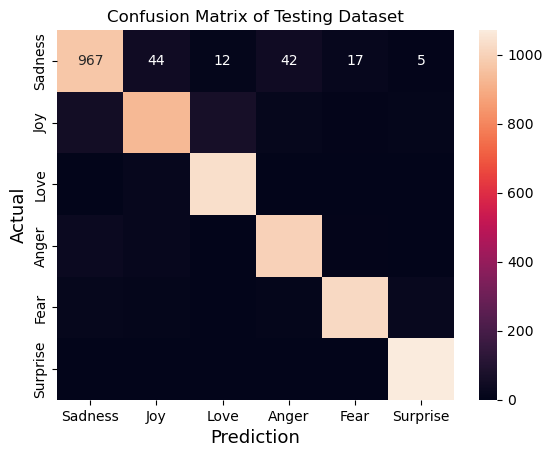

In [136]:
sns.heatmap(test_cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Testing Dataset',fontsize=12)
plt.show()

In [137]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3850
           1       1.00      0.99      0.99      3876
           2       0.99      1.00      1.00      3888
           3       0.99      1.00      0.99      3885
           4       0.99      0.99      0.99      3855
           5       0.99      1.00      1.00      3809

    accuracy                           0.99     23163
   macro avg       0.99      0.99      0.99     23163
weighted avg       0.99      0.99      0.99     23163



In [138]:
report_svm=classification_report(y_test, y_test_pred,output_dict=True)
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1087
           1       0.91      0.86      0.89      1078
           2       0.92      0.98      0.95      1059
           3       0.94      0.94      0.94      1057
           4       0.97      0.94      0.96      1081
           5       0.97      1.00      0.98      1073

    accuracy                           0.94      6435
   macro avg       0.94      0.94      0.94      6435
weighted avg       0.94      0.94      0.94      6435



In [139]:
print("Classification Report on Validation Data:\n",classification_report(y_val, y_val_pred))

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       425
           1       0.88      0.87      0.87       408
           2       0.92      0.97      0.94       415
           3       0.95      0.95      0.95       420
           4       0.98      0.95      0.96       426
           5       0.97      1.00      0.99       480

    accuracy                           0.94      2574
   macro avg       0.94      0.94      0.94      2574
weighted avg       0.94      0.94      0.94      2574



### XGBoost Algorithm

In [140]:
xgb_classifier = XGBClassifier()

In [141]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [142]:
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

In [143]:
xgb_train_acc = accuracy_score(y_train, y_train_pred)
xgb_test_acc = accuracy_score(y_test, y_test_pred)

In [144]:
print("Training Accuracy:", xgb_train_acc)
print("Testing Accuracy:", xgb_test_acc)

Training Accuracy: 0.9632603721452316
Testing Accuracy: 0.922921522921523


In [145]:
before_train.append(xgb_train_acc)
before_test.append(xgb_test_acc)

In [146]:
cm = confusion_matrix(y_train,y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3594   89   22   80   53   12]
 [  32 3580  182   22   26   34]
 [   6   55 3819    5    2    1]
 [  20   58    5 3781   17    4]
 [   9   25    0   37 3740   44]
 [   0    0    0    0   11 3798]]


In [147]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 944   51   17   40   28    7]
 [  25  943   69   10   15   16]
 [   6   37 1014    1    0    1]
 [  18   21    2 1000   14    2]
 [   7   22    5   25  976   46]
 [   1    2    0    0    8 1062]]


In [148]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      3850
           1       0.94      0.92      0.93      3876
           2       0.95      0.98      0.96      3888
           3       0.96      0.97      0.97      3885
           4       0.97      0.97      0.97      3855
           5       0.98      1.00      0.99      3809

    accuracy                           0.96     23163
   macro avg       0.96      0.96      0.96     23163
weighted avg       0.96      0.96      0.96     23163



In [149]:
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1087
           1       0.88      0.87      0.88      1078
           2       0.92      0.96      0.94      1059
           3       0.93      0.95      0.94      1057
           4       0.94      0.90      0.92      1081
           5       0.94      0.99      0.96      1073

    accuracy                           0.92      6435
   macro avg       0.92      0.92      0.92      6435
weighted avg       0.92      0.92      0.92      6435



#### Hyeperparameter Tuning

In [150]:
# Define a grid of hyperparameters to search over for XGBoost
param_grid = {
    'n_estimators': [100, 200],   # Number of boosting rounds (decision trees)
    'subsample': [0.8, 1.0]        # Subsample ratio of the training instances
}

In [151]:
xgb_classifier = XGBClassifier()

In [152]:
# Create a GridSearchCV object for XGBoost
xgb_grid = GridSearchCV(
    estimator=xgb_classifier,   # The XGBoost classifier
    param_grid=param_grid,      # The grid of hyperparameters to search over
    cv=5,                       # Cross-validation strategy (5-fold cross-validation)
    scoring='accuracy',         # Scoring metric to optimize (accuracy)
    n_jobs=-1,                  # Number of jobs to run in parallel (-1 uses all available CPU cores)
    verbose=2                   # Controls the verbosity of the output (more details)
)

In [154]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [155]:
print("Best Parameters:", xgb_grid.best_params_)
param.append(xgb_grid.best_params_)

Best Parameters: {'n_estimators': 200, 'subsample': 1.0}


In [156]:
best_xgb = xgb_grid.best_estimator_

In [157]:
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)
y_val_pred = best_xgb.predict(X_val)

In [158]:
xgb_train_hpt = accuracy_score(y_train, y_train_pred)
xgb_test_hpt = accuracy_score(y_test, y_test_pred)
xgb_val_hpt = accuracy_score(y_val, y_val_pred)

In [159]:
print("Training Accuracy with Best Estimator:", xgb_train_hpt)
print("Testing Accuracy with Best Estimator:", xgb_test_hpt)
print("Validation Accuracy with Best Estimator:", xgb_val_hpt)

Training Accuracy with Best Estimator: 0.982428873634676
Testing Accuracy with Best Estimator: 0.9358197358197358
Validation Accuracy with Best Estimator: 0.9378399378399378


In [160]:
after_train.append(xgb_train_hpt)
after_test.append(xgb_test_hpt)
val.append(xgb_val_hpt)

In [161]:
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix of Training Dataset\n",cm)

Confusion Matrix of Training Dataset
 [[3723   22    3   61   40    1]
 [  11 3703  109   19   13   21]
 [   2   20 3864    1    1    0]
 [  12    7    0 3852   13    1]
 [   4    1    0   32 3811    7]
 [   0    0    0    0    6 3803]]


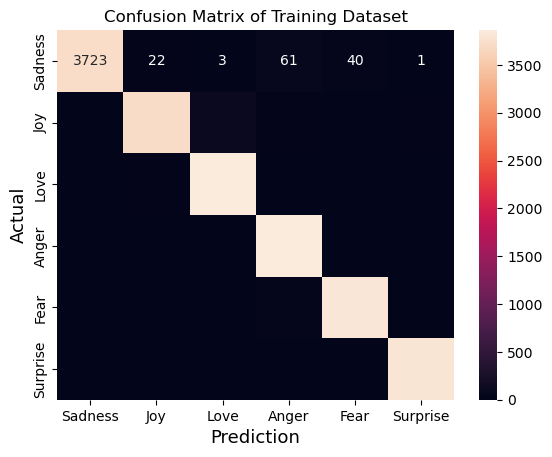

In [162]:
sns.heatmap(cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Training Dataset',fontsize=12)
plt.show()

In [163]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix of Testing Dataset\n",test_cm)

Confusion Matrix of Testing Dataset
 [[ 979   27   13   36   27    5]
 [  21  960   55   14   15   13]
 [   4   45 1009    0    1    0]
 [  18   11    0 1013   13    2]
 [   7    9    2   26 1001   36]
 [   1    2    0    0   10 1060]]


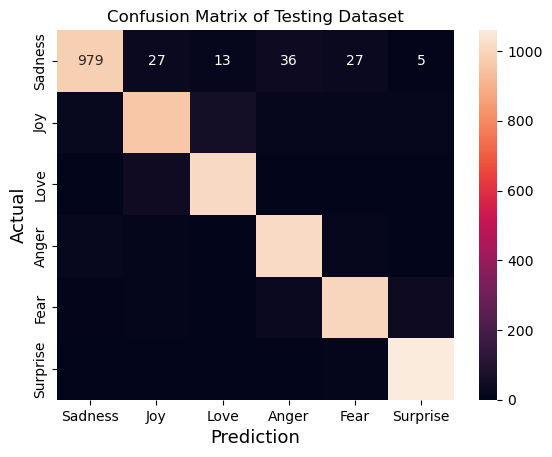

In [164]:
sns.heatmap(test_cm, annot=True,fmt='g', xticklabels=class_names.values(),yticklabels=class_names.values())
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix of Testing Dataset',fontsize=12)
plt.show()

In [165]:
print("Classification Report on Training Data:\n",classification_report(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3850
           1       0.99      0.96      0.97      3876
           2       0.97      0.99      0.98      3888
           3       0.97      0.99      0.98      3885
           4       0.98      0.99      0.98      3855
           5       0.99      1.00      1.00      3809

    accuracy                           0.98     23163
   macro avg       0.98      0.98      0.98     23163
weighted avg       0.98      0.98      0.98     23163



In [166]:
report_xgb=classification_report(y_test, y_test_pred,output_dict=True)
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92      1087
           1       0.91      0.89      0.90      1078
           2       0.94      0.95      0.94      1059
           3       0.93      0.96      0.94      1057
           4       0.94      0.93      0.93      1081
           5       0.95      0.99      0.97      1073

    accuracy                           0.94      6435
   macro avg       0.94      0.94      0.94      6435
weighted avg       0.94      0.94      0.94      6435



In [167]:
print("Classification Report on Training Data:\n",classification_report(y_val, y_val_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       425
           1       0.89      0.89      0.89       408
           2       0.93      0.96      0.94       415
           3       0.92      0.97      0.94       420
           4       0.96      0.93      0.95       426
           5       0.96      0.99      0.97       480

    accuracy                           0.94      2574
   macro avg       0.94      0.94      0.94      2574
weighted avg       0.94      0.94      0.94      2574



### Evaluation

In [168]:
# Evaluating based on accuracy score of training and testing before and after hyperparameter tuning

In [169]:
df1 = {
    'Model': algorithm,
    'Before_train': before_train,
    'Before_test': before_test,
    'After_train': after_train,
    'After_test': after_test
}

In [170]:
df1_result = pd.DataFrame(df1)

In [171]:
print(df1_result)

                 Model  Before_train  Before_test  After_train  After_test
0        Random Forest      0.999266     0.928361     0.833010    0.810878
1  Logistic Regression      0.957648     0.928361     0.987782    0.941570
2          Naive Bayes      0.943876     0.905361     0.949575    0.904274
3                  SVM      0.967146     0.931779     0.993654    0.935820
4              XGBoost      0.963260     0.922922     0.982429    0.935820


In [172]:
# Evaluating based on precision, recall, F1-score and accuracy

In [173]:
df2 = {
    "Model":algorithm,
    "Precision": [report_rf['weighted avg']['precision'], report_log['weighted avg']['precision'], report_nb['weighted avg']['precision'], report_svm['weighted avg']['precision'], report_xgb['weighted avg']['precision']],
    "Recall": [report_rf['weighted avg']['recall'], report_log['weighted avg']['recall'], report_nb['weighted avg']['recall'], report_svm['weighted avg']['recall'], report_xgb['weighted avg']['recall']],
    "F1-Score": [report_rf['weighted avg']['f1-score'], report_log['weighted avg']['f1-score'], report_nb['weighted avg']['f1-score'], report_svm['weighted avg']['f1-score'], report_xgb['weighted avg']['f1-score']],
    "Accuracy": after_test
    
}

In [174]:
df2_result= pd.DataFrame(df2)

In [175]:
print(df2_result)

                 Model  Precision    Recall  F1-Score  Accuracy
0        Random Forest   0.815850  0.810878  0.809063  0.810878
1  Logistic Regression   0.941629  0.941570  0.941339  0.941570
2          Naive Bayes   0.904310  0.904274  0.903147  0.904274
3                  SVM   0.935575  0.935820  0.935382  0.935820
4              XGBoost   0.935798  0.935820  0.935559  0.935820


In [176]:
# Evaluating based on accuracy score of validation dataset

In [177]:
df3={
    "Model":algorithm,
    "Validation Accuracy":val
}

In [178]:
df3_result=pd.DataFrame(df3)

In [179]:
print(df3_result)

                 Model  Validation Accuracy
0        Random Forest             0.816628
1  Logistic Regression             0.947941
2          Naive Bayes             0.907537
3                  SVM             0.937451
4              XGBoost             0.937840


In [180]:
# Displaying best params of hyperparameter tuning

In [181]:
df4={
    "Model":algorithm,
    "Best Param":param
}

In [182]:
df4_result= pd.DataFrame(df4)

In [183]:
print(df4_result)

                 Model                                         Best Param
0        Random Forest  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...
1  Logistic Regression                   {'C': 10, 'solver': 'newton-cg'}
2          Naive Bayes                                     {'alpha': 0.5}
3                  SVM                                          {'C': 10}
4              XGBoost            {'n_estimators': 200, 'subsample': 1.0}


### Conclusion

Based on the provided metrics, **Logistic Regression** appears to be the best model overall. It has the highest accuracy after testing and the highest validation accuracy. It's also consistent across all metrics. Therefore, Logistic Regression may be the preferred choice for your classification task.
